In [1]:
%load_ext autoreload
%autoreload
from IPython.display import clear_output

import os
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import sys
import subprocess
import pdb
import time
import datetime
import math
import random
import _pickle as cPickle
from collections import defaultdict
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib nbagg

from six.moves import zip_longest
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import distributions as tfd
from tensorflow.keras.preprocessing.sequence import pad_sequences

from data_structure import get_batches, get_test_batches
from components import tf_log, sample_latents, compute_kl_loss, dynamic_rnn, dynamic_bi_rnn

from topic_beam_search_decoder import BeamSearchDecoder

In [2]:
PAD = '<pad>' # This has a vocab id, which is used to pad the encoder input, decoder input and target sequence
UNK = '<unk>' # This has a vocab id, which is used to represent out-of-vocabulary words
BOS = '<p>' # This has a vocab id, which is used at the beginning of every decoder input sequence
EOS = '</p>' # This has a vocab id, which is used at the end of untruncated target sequences

# load data & set config

In [3]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

flags = tf.app.flags

flags.DEFINE_string('gpu', '3', 'visible gpu')

flags.DEFINE_string('mode', 'train', 'set train or eval')

flags.DEFINE_string('data_path', 'data/synthetic/instances_ncrp.pkl', 'path of data')
flags.DEFINE_string('modeldir', 'model/topic_vae', 'directory of model')
flags.DEFINE_string('modelname', 'bags', 'name of model')

flags.DEFINE_integer('epochs', 1000, 'epochs')
flags.DEFINE_integer('batch_size', 64, 'number of sentences in each batch')
flags.DEFINE_integer('log_period', 1000, 'valid period')

flags.DEFINE_string('opt', 'Adagrad', 'optimizer')
# flags.DEFINE_string('opt', 'Adam', 'optimizer')
flags.DEFINE_float('lr', 0.01, 'lr')
flags.DEFINE_float('reg', 10., 'regularization term')
flags.DEFINE_float('grad_clip', 5., 'grad_clip')

flags.DEFINE_float('keep_prob', 0.8, 'dropout rate')
flags.DEFINE_float('word_keep_prob', 0.75, 'word dropout rate')

flags.DEFINE_bool('warmup', True, 'flg of warming up')
flags.DEFINE_integer('epochs_cycle', 5, 'number of epochs within a cycle')
flags.DEFINE_float('r_cycle', 0.5, 'proportion used to increase beta within a cycle')
flags.DEFINE_integer('warmup_topic', 0, 'warmup period for KL of topic')

flags.DEFINE_integer('beam_width', 2, 'beam_width')
flags.DEFINE_float('length_penalty_weight', 0.0, 'length_penalty_weight')

flags.DEFINE_integer('n_topic', 20, 'number of topic')
flags.DEFINE_integer('dim_hidden_bow', 256, 'dim of hidden bow')
flags.DEFINE_integer('dim_latent_bow', 32, 'dim of latent topic')
flags.DEFINE_integer('dim_emb', 256, 'dim_emb')
flags.DEFINE_integer('dim_hidden', 512, 'dim_hidden')
flags.DEFINE_integer('dim_hidden_topic', 512, 'dim_hidden_topic')
flags.DEFINE_integer('dim_latent', 32, 'dim_latent')
flags.DEFINE_bool('bidirectional', True, 'flg of bidirectional encoding')

# for evaluation
flags.DEFINE_string('refdir', 'ref', 'refdir')
flags.DEFINE_string('outdir', 'out', 'outdir')

flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_bool('logtostderr', True, 'kernel')
flags.DEFINE_bool('showprefixforinfo', False, '')
flags.DEFINE_bool('verbosity', False, '')
# flags.DEFINE_integer('stderrthreshold', 20, 'kernel')

config = flags.FLAGS

flags.DEFINE_string('modelpath', os.path.join(config.modeldir, config.modelname), 'path of model')

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = config.gpu

In [5]:
instances_train, instances_dev, instances_test, word_to_idx, idx_to_word, bow_idxs = cPickle.load(open(config.data_path,'rb'))

In [6]:
def get_batches(instances, batch_size, iterator=False):
    iter_instances = iter(instances)
    n_batch = len(instances)//batch_size
    
    batches = [(i_batch, [next(iter_instances) for i_doc in range(batch_size)]) for i_batch in range(n_batch)]
    
    if iterator: batches = iter(batches)
    return batches

train_batches = get_batches(instances_train, config.batch_size)
dev_batches = get_batches(instances_dev, config.batch_size)
test_batches = get_batches(instances_test, config.batch_size)

In [7]:
flags.DEFINE_integer('n_vocab', len(word_to_idx), 'n_vocab')
flags.DEFINE_integer('dim_bow', len(bow_idxs), 'dim_bow')

flags.DEFINE_integer('cycle_steps', len(train_batches)*config.epochs_cycle, 'number of steps for each cycle')

In [8]:
def debug_shape(variables):
    sample_batch = dev_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable.shape)
        else:
            print(_variable.shape)

def debug_value(variables, return_value=False):
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)

    if return_value: 
        return _variables
    else:
        for _variable, variable in zip(_variables, variables):
            if hasattr(variable, 'name'):
                print(variable.name, ':', _variable)
            else:
                print(_variable)
                
def check_shape(variables):
    if 'sess' in globals(): raise
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable.shape)
        else:
            print(_variable.shape)
            
    sess.close()
    
def check_value(variables):
    if 'sess' in globals(): raise
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable)
        else:
            print(_variable.shape)
            
    sess.close()    
    

# run model 

## init

In [9]:
def get_feed_dict(batch, mode='train'):
    bow = np.array([instance.bow for instance in batch]).astype(np.float32)
    keep_prob = config.keep_prob if mode == 'train' else 1.0
    feed_dict = {
                t_variables['bow']: bow, 
                t_variables['keep_prob']: keep_prob
    }
    return  feed_dict

In [10]:
tf.reset_default_graph()

def get_depth(parent_idx=0, tree_depth=None, depth=1):
    if tree_depth is None: tree_depth={0: depth}

    child_idxs = tree_idxs[parent_idx]
    depth +=1
    for child_idx in child_idxs:
        tree_depth[child_idx] = depth
        if child_idx in tree_idxs: get_depth(child_idx, tree_depth, depth)
    return tree_depth

t_variables = {}
t_variables['bow'] = tf.placeholder(tf.float32, [None, config.dim_bow])
t_variables['keep_prob'] = tf.placeholder(tf.float32)

# tree_idxs = {0:[1, 2, 3], 
#                       1:[10, 11], 2:[20, 21], 3:[30, 31]}

tree_idxs = {0:[1, 2, 3], 
              1:[10, 11, 12], 2:[20, 21, 22], 3:[30, 31, 32]}

# tree_idxs = {0:[1, 2], 
#              1:[11, 12], 2:[21]}

# tree_idxs = {0:[1, 2, 3], 
#                       1:[10, 11], 2:[20, 21], 3:[30, 31],
#                       10: [100, 101], 11: [110, 111], 20: [200, 201], 21: [210, 211], 30:[300, 301], 31:[310, 311]}

topic_idxs = [0] + [idx for child_idxs in tree_idxs.values() for idx in child_idxs]

child_to_parent_idxs = {child_idx: parent_idx for parent_idx, child_idxs in tree_idxs.items() for child_idx in child_idxs}

tree_depth = get_depth()
max_depth = max(tree_depth.values())

## doubly rnn

In [11]:
class DoublyRNNCell:
    def __init__(self, dim_hidden, output_layer=None):
        self.dim_hidden = dim_hidden
        
        self.ancestral_layer=tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='ancestral')
        self.fraternal_layer=tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='fraternal')
#         self.hidden_layer = tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='hidden')
        self.hidden_layer = tf.layers.Dense(units=dim_hidden, name='hidden')
        
        self.output_layer=output_layer
        
    def __call__(self, state_ancestral, state_fraternal, reuse=True):
        with tf.variable_scope('input', reuse=reuse):
            state_ancestral = self.ancestral_layer(state_ancestral)
            state_fraternal = self.fraternal_layer(state_fraternal)

        with tf.variable_scope('output', reuse=reuse):
            state_hidden = self.hidden_layer(state_ancestral + state_fraternal)
            if self.output_layer is not None: 
                output = self.output_layer(state_hidden)
            else:
                output = state_hidden
            
        return output, state_hidden
    
    def get_initial_state(self, name):
        initial_state = tf.get_variable(name, [1, self.dim_hidden], dtype=tf.float32)
        return initial_state
    
    def get_zero_state(self, name):
        zero_state = tf.zeros([1, self.dim_hidden], dtype=tf.float32, name=name)
        return zero_state

In [12]:
def doubly_rnn(dim_hidden, tree_idxs, initial_state_parent=None, initial_state_sibling=None, output_layer=None, name=''):
    outputs, states_parent = {}, {}
    
    with tf.variable_scope(name, reuse=False):
        doubly_rnn_cell = DoublyRNNCell(dim_hidden, output_layer)

        if initial_state_parent is None: 
            initial_state_parent = doubly_rnn_cell.get_initial_state('init_state_parent')
#             initial_state_parent = doubly_rnn_cell.get_zero_state('init_state_parent')
        if initial_state_sibling is None: 
#             initial_state_sibling = doubly_rnn_cell.get_initial_state('init_state_sibling')
            initial_state_sibling = doubly_rnn_cell.get_zero_state('init_state_sibling')
        output, state_sibling = doubly_rnn_cell(initial_state_parent, initial_state_sibling, reuse=False)
        outputs[0], states_parent[0] = output, state_sibling

        for parent_idx, child_idxs in tree_idxs.items():
            state_parent = states_parent[parent_idx]
            state_sibling = initial_state_sibling
            for child_idx in child_idxs:
                output, state_sibling = doubly_rnn_cell(state_parent, state_sibling)
                outputs[child_idx], states_parent[child_idx] = output, state_sibling

    return outputs, states_parent

## rnn

In [13]:
class RNNCell:
    def __init__(self, dim_hidden, output_layer=None):
        self.dim_hidden = dim_hidden
        self.hidden_layer = tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='hidden')
        self.output_layer=output_layer
        
    def __call__(self, state, reuse=True):
        with tf.variable_scope('output', reuse=reuse):
            state_hidden = self.hidden_layer(state)
            if self.output_layer is not None: 
                output = self.output_layer(state_hidden)
            else:
                output = state_hidden
            
        return output, state_hidden
    
    def get_initial_state(self, name):
        initial_state = tf.get_variable(name, [1, self.dim_hidden], dtype=tf.float32)
        return initial_state
    
    def get_zero_state(self, name):
        zero_state = tf.zeros([1, self.dim_hidden], dtype=tf.float32, name=name)
        return zero_state

In [14]:
def rnn(dim_hidden, max_depth, initial_state=None, output_layer=None, name=''):
    outputs, states_hidden = [], []
    
    with tf.variable_scope(name, reuse=False):
        rnn_cell = RNNCell(dim_hidden, output_layer)

        if initial_state is not None: 
            state_hidden = initial_state
        else:
            state_hidden = rnn_cell.get_initial_state('init_state')
#             state_hidden = rnn_cell.get_zero_state('init_state_parent')
        
        for depth in range(max_depth):
            if depth == 0:                
                output, state_hidden = rnn_cell(state_hidden, reuse=False)
            else:
                output, state_hidden = rnn_cell(state_hidden, reuse=True)
            outputs.append(output)
            states_hidden.append(state_hidden)

    outputs = tf.concat(outputs, 1)
    states_hidden = tf.concat(states_hidden, 0)
    return outputs, states_hidden

## stick break

In [15]:
def nCRP(tree_sticks_topic):
    tree_prob_topic = {}
    tree_prob_leaf = {}
    # calculate topic probability and save
    tree_prob_topic[0] = 1.
    
    for parent_idx, child_idxs in tree_idxs.items():
        rest_prob_topic = tree_prob_topic[parent_idx]
        for child_idx in child_idxs:
            stick_topic = tree_sticks_topic[child_idx]
            if child_idx == child_idxs[-1]:
                prob_topic = rest_prob_topic * 1.
            else:
                prob_topic = rest_prob_topic * stick_topic
            
            if not child_idx in tree_idxs: # leaf childs
                tree_prob_leaf[child_idx] = prob_topic
            else:
                tree_prob_topic[child_idx] = prob_topic
                
            rest_prob_topic -= prob_topic
            
    return tree_prob_leaf

def sbp(sticks_depth, max_depth):
    prob_depth_list = []
    rest_prob_depth = 1.
    for depth in range(max_depth):
        stick_depth = tf.expand_dims(sticks_depth[:, depth], 1)
        if depth == max_depth -1:
            prob_depth = rest_prob_depth * 1.
        else:
            prob_depth = rest_prob_depth * stick_depth
        prob_depth_list.append(prob_depth)
        rest_prob_depth -= prob_depth
    
    prob_depth = tf.concat(prob_depth_list, 1)
    return prob_depth

def get_ancestor_idxs(leaf_idx, ancestor_idxs = None):
    if ancestor_idxs is None: ancestor_idxs = [leaf_idx]
    
    parent_idx = child_to_parent_idxs[leaf_idx]
    ancestor_idxs += [parent_idx]
    if parent_idx in child_to_parent_idxs: get_ancestor_idxs(parent_idx, ancestor_idxs)
    return ancestor_idxs[::-1]

def get_prob_topic(tree_prob_leaf, prob_depth):
    tree_prob_topic = defaultdict(float)
    
    leaf_ancestor_idxs = {leaf_idx: get_ancestor_idxs(leaf_idx) for leaf_idx in tree_prob_leaf}
    for leaf_idx, ancestor_idxs in leaf_ancestor_idxs.items():
        prob_leaf = tree_prob_leaf[leaf_idx]
        for i, ancestor_idx in enumerate(ancestor_idxs):
            prob_ancestor = prob_leaf * tf.expand_dims(prob_depth[:, i], -1)
            tree_prob_topic[ancestor_idx] += prob_ancestor
    prob_topic = tf.concat([tree_prob_topic[topic_idx] for topic_idx in topic_idxs], -1)
    return prob_topic

## build model

In [16]:
def get_tree_topic_bow(tree_topic_embeddings):
    def softmax_with_temperature(logits, axis=None, name=None, temperature=1.):
        if axis is None:
            axis = -1
        return tf.exp(logits / temperature) / tf.reduce_sum(tf.exp(logits / temperature), axis=axis)

    tree_topic_bow = {}
    for topic_idx, depth in tree_depth.items():
        topic_embedding = tree_topic_embeddings[topic_idx]
        temperature = tf.constant(10. * (10 ** (1./depth)), dtype=tf.float32)
        logits = tf.matmul(topic_embedding, bow_embeddings, transpose_b=True)
        tree_topic_bow[topic_idx] = softmax_with_temperature(logits, axis=-1, temperature=temperature)
    
    return tree_topic_bow

In [17]:
# encode bow
with tf.variable_scope('topic/enc', reuse=False):
    hidden_bow_ = tf.layers.Dense(units=config.dim_hidden_bow, activation=tf.nn.tanh, name='hidden_bow')(t_variables['bow'])
    hidden_bow = tf.layers.Dropout(t_variables['keep_prob'])(hidden_bow_)
    means_bow = tf.layers.Dense(units=config.dim_latent_bow, name='mean_bow')(hidden_bow)
    logvars_bow = tf.layers.Dense(units=config.dim_latent_bow, kernel_initializer=tf.constant_initializer(0), bias_initializer=tf.constant_initializer(0), name='logvar_bow')(hidden_bow)
    latents_bow = sample_latents(means_bow, logvars_bow) # sample latent vectors
    prob_layer = lambda h: tf.nn.sigmoid(tf.matmul(latents_bow, h, transpose_b=True))
    
    tree_sticks_topic, tree_states_sticks_topic = doubly_rnn(config.dim_latent_bow, tree_idxs, output_layer=prob_layer, name='sticks_topic')
    tree_prob_leaf = nCRP(tree_sticks_topic)
#     prob_depth = tf.layers.Dense(units=max_depth, activation=tf.nn.softmax, name='prob_depth')(latents_bow) # inference of topic probabilities
    sticks_depth, _ = rnn(config.dim_latent_bow, max_depth, output_layer=prob_layer, name='prob_depth')
    prob_depth = sbp(sticks_depth, max_depth)
    
    prob_topic = get_prob_topic(tree_prob_leaf, prob_depth)

# decode bow
with tf.variable_scope('shared', reuse=False):
    embeddings = tf.get_variable('emb', [config.n_vocab, config.dim_emb], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer()) # embeddings of vocab

bow_embeddings = tf.nn.embedding_lookup(embeddings, bow_idxs) # embeddings of each bow features

with tf.variable_scope('topic/dec', reuse=False):
#     tree_topic_embeddings, tree_states_topic_embeddings = doubly_rnn(config.dim_emb, tree_idxs, name='emb_topic')
    emb_layer = lambda h: tf.layers.Dense(units=config.dim_emb, name='output')(tf.nn.tanh(h))
    tree_topic_embeddings, tree_states_topic_embeddings = doubly_rnn(config.dim_emb, tree_idxs, output_layer=emb_layer, name='emb_topic')
#     topic_embeddings = tf.get_variable('topic_emb', [len(topic_idxs), config.dim_emb], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer()) # embeddings of topics
#     tree_topic_embeddings = {topic_idx: tf.expand_dims(topic_embeddings[topic_idxs.index(topic_idx)], 0) for topic_idx in topic_idxs}

    tree_topic_bow = get_tree_topic_bow(tree_topic_embeddings) # bow vectors for each topic
    
    topic_bow = tf.concat([tree_topic_bow[topic_idx] for topic_idx in topic_idxs], 0)
    logits_bow = tf_log(tf.matmul(prob_topic, topic_bow)) # predicted bow distribution

## define loss

In [18]:
def get_tree_mask_reg(tree_idxs):
    tree_mask_reg = np.ones([len(topic_idxs), len(topic_idxs)], dtype=np.float32)
    parent_to_descendant_idxs = {parent_idx: get_descendant_idxs(parent_idx) for parent_idx in tree_idxs}
    
    for parent_idx, descendant_idxs in parent_to_descendant_idxs.items():
        for descendant_idx in descendant_idxs:
            tree_mask_reg[topic_idxs.index(parent_idx), topic_idxs.index(descendant_idx)] = tree_mask_reg[topic_idxs.index(descendant_idx), topic_idxs.index(parent_idx)] = 0.
            
    return tree_mask_reg

def get_depth_mask_reg(tree_idxs):
    depth_mask_reg = np.zeros([len(topic_idxs), len(topic_idxs)], dtype=np.float32)

    depth_topic_idxs = defaultdict(list)
    for topic_idx, _depth in tree_depth.items():
        depth_topic_idxs[_depth].append(topic_idx)
    
    for _depth, child_idxs in depth_topic_idxs.items():
        for child_idx1 in child_idxs:
            for child_idx2 in child_idxs:
                depth_mask_reg[topic_idxs.index(child_idx1), topic_idxs.index(child_idx2)] = 1.
                
    return depth_mask_reg

def get_descendant_idxs(parent_idx, descendant_idxs = None):
    if descendant_idxs is None: descendant_idxs = []
    
    child_idxs = tree_idxs[parent_idx]
    descendant_idxs += child_idxs
    for child_idx in child_idxs:
        if child_idx in tree_idxs: get_descendant_idxs(child_idx, descendant_idxs)
    return descendant_idxs

In [19]:
# define losses
topic_losses_recon = -tf.reduce_sum(tf.multiply(t_variables['bow'], logits_bow), 1)
topic_loss_recon = tf.reduce_mean(topic_losses_recon) # negative log likelihood of each words

topic_loss_kl = compute_kl_loss(means_bow, logvars_bow) # KL divergence b/w latent dist & gaussian std

topic_bow_norm = topic_bow / tf.norm(topic_bow, axis=1, keepdims=True)
topic_dots = tf.clip_by_value(tf.matmul(topic_bow_norm, tf.transpose(topic_bow_norm)), -1., 1.)
# topic_loss_reg = tf.reduce_mean(tf.square(topic_dots - tf.eye(len(topic_idxs))))
tree_mask_reg = get_tree_mask_reg(tree_idxs)
# tree_mask_reg = get_depth_mask_reg(tree_idxs)
topic_losses_reg = tf.square(topic_dots - tf.eye(len(topic_idxs))) * tree_mask_reg
topic_loss_reg = tf.reduce_sum(topic_losses_reg) / tf.reduce_sum(tree_mask_reg)

# topic_embeddings = tf.concat([tree_topic_embeddings[topic_idx] for topic_idx in topic_idxs], 0)
# topic_embeddings_norm = topic_embeddings / tf.norm(topic_embeddings, axis=1, keepdims=True)
# topic_dots = tf.clip_by_value(tf.matmul(topic_embeddings_norm, tf.transpose(topic_embeddings_norm)), -1., 1.)
# tree_mask_reg = get_tree_mask_reg(tree_idxs)
# topic_loss_reg = tf.reduce_sum(tf.square(topic_dots - tf.eye(len(topic_idxs))) * tree_mask_reg) / tf.reduce_sum(tree_mask_reg)

# topic_embeddings = tf.concat([tree_topic_embeddings[topic_idx] for topic_idx in topic_idxs], 0)
# topic_embeddings_norm = topic_embeddings / tf.norm(topic_embeddings, axis=1, keepdims=True)
# topic_dots = tf.clip_by_value(tf.matmul(topic_embeddings_norm, tf.transpose(topic_embeddings_norm)), -1., 1.)
# topic_angles = tf.acos(topic_dots)
# tree_mask_reg = get_tree_mask_reg(tree_idxs)

# mean_angles = tf.reduce_sum(topic_angles*tree_mask_reg) / tf.reduce_sum(tree_mask_reg)
# var_angles = tf.reduce_sum(tf.square(topic_angles-mean_angles)*tree_mask_reg) / tf.reduce_sum(tree_mask_reg)
# mean_angles = tf.reduce_mean(topic_angles)
# var_angles = tf.reduce_mean(tf.square(topic_angles-mean_angles))
# mean_angles = tf.asin(tf.sqrt(tf.linalg.det(topic_dots * tree_mask_reg)))
# var_angles = tf.square(tf.constant(np.pi/2., dtype=tf.float32)-mean_angles)

# topic_loss_reg = var_angles - mean_angles

global_step = tf.Variable(0, name='global_step',trainable=False)

loss = topic_loss_recon + topic_loss_kl + config.reg * topic_loss_reg

# define optimizer
if config.opt == 'Adam':
    optimizer = tf.train.AdamOptimizer(config.lr)
elif config.opt == 'Adagrad':
    optimizer = tf.train.AdagradOptimizer(config.lr)

grad_vars = optimizer.compute_gradients(loss)
clipped_grad_vars = [(tf.clip_by_value(grad, -config.grad_clip, config.grad_clip), var) for grad, var in grad_vars]
opt = optimizer.apply_gradients(clipped_grad_vars, global_step=global_step)

# monitor
n_bow = tf.reduce_sum(t_variables['bow'], 1)
topic_ppls = tf.divide(topic_losses_recon, tf.maximum(1e-5, n_bow))
topics_freq_bow_indices = tf.nn.top_k(topic_bow, 5, name='topic_freq_bow').indices

In [20]:
def get_loss(sess, batches):
    losses = []
    ppl_list = []
    for ct, batch in batches:
        feed_dict = get_feed_dict(batch, mode='test')
        loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch, ppls_batch \
            = sess.run([loss, topic_loss_recon, topic_loss_kl, topic_loss_reg, topic_ppls], feed_dict = feed_dict)
        losses += [[loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch]]
        ppl_list += list(ppls_batch)
    loss_mean, topic_loss_recon_mean, topic_loss_kl_mean, topic_loss_reg_mean = np.mean(losses, 0)
    ppl_mean = np.exp(np.mean(ppl_list))
    return loss_mean, topic_loss_recon_mean, topic_loss_kl_mean, topic_loss_reg_mean, ppl_mean

In [21]:
from matplotlib.colors import Normalize # Normalizeをimport

def print_topic_sample():
    _topics_bow = sess.run(topic_bow)
    plt.figure(figsize=(9, 15))
    
    _topic_bow = _topics_bow[0]
    plt.subplot(5,3,2)
    plt.axis('off')
    plt.title(topic_idxs[0])
    plt.imshow(_topic_bow.reshape(30,30), cmap='Wistia', norm=Normalize(vmin=0., vmax=0.01))
    
    for i in range(1, len(topic_idxs)):
        _topic_bow = _topics_bow[i]
        plt.subplot(5,3,i+3)
        plt.axis('off')
        plt.title(topic_idxs[i])
        plt.imshow(_topic_bow.reshape(30,30), cmap='Wistia', norm=Normalize(vmin=0., vmax=0.01))
        
    plt.show()

In [22]:
if 'sess' in globals(): sess.close()
sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1))
sess.run(tf.global_variables_initializer())

losses_train = []
ppls_train = []
loss_min = np.inf
beta_eval = 1.
epoch = 0
train_batches = get_batches(instances_train, config.batch_size, iterator=True)
saver = tf.train.Saver(max_to_keep=10)

log_df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
                    list(zip(*[['','','','TRAIN:','TM','','','','VALID:','TM','','',''],
                            ['Time','Ep','Ct','LOSS','PPL','NLL','KL','REG','LOSS','PPL','NLL','KL','REG']]))))

TRAIN:   TM                      VALID:   TM          \
      Time   Ep   Ct    LOSS  PPL     NLL    KL   REG    LOSS  PPL     NLL   
1000    13    6   63  685.56  874  677.26  0.95  0.74  679.81  849  674.41   
2000    11   12  127  681.42  849  674.44  1.34  0.56  677.04  822  671.22   
3000    11   19   35  679.48  836  672.87  1.58  0.50  676.17  816  670.46   
4000    11   25   99  678.37  828  671.94  1.72  0.47  675.75  812  669.99   
5000    11   32    7  677.59  823  671.29  1.82  0.45  674.96  807  669.30   
6000    11   38   71  676.92  818  670.74  1.93  0.43  674.31  802  668.71   
7000    11   44  135  676.22  815  670.27  2.03  0.39  672.53  801  668.57   
8000    11   51   43  675.58  811  669.87  2.12  0.36  672.14  798  668.18   
9000    11   57  107  675.07  809  669.55  2.20  0.33  672.02  797  668.14   
10000   11   64   15  674.64  807  669.27  2.27  0.31  671.90  796  667.93   
11000   11   70   79  674.28  805  669.03  2.32  0.29  671.77  795  667.79   
12000   11   76  143  673.95  803  668.79  2.39  0.28  671.36  790  667.26   
13000   11   83   51  673.65  801  668.56  2.47  0.26  671.17  788  666.97   
14000   11   89  115  673.38  799  668.35  2.54  0.25  670.93  786  666.74   
15000   11   96   23  673.13  797  668.14  2.61  0.24  670.64  783  666.34   
16000   11  102   87  672.89  796  667.95  2.68  0.23  670.46  782  666.15   
17000   11  108  151  672.68  794  667.77  2.75  0.22  670.31  780  665.94   
18000   11  115   59  672.49  793  667.60  2.81  0.21  670.31  780  665.87   
19000   11  121  123  672.31  792  667.44  2.87  0.20  670.31  779  665.83   
20000   11  128   31  672.15  791  667.29  2.92  0.19  670.17  778  665.61   
21000   11  134   95  671.99  790  667.15  2.98  0.19  670.07  777  665.50   
22000   11  141    3  671.85  789  667.02  3.03  0.18  669.95  775  665.33   
23000   11  147   67  671.72  788  666.89  3.08  0.17  669.90  774  665.21   
24000   11  153  131  671.59  787  666.76  3.13  0.17  669.75  773  665.02   
25000   11  160   39  671.48  786  666.65  3.18  0.16  669.75  772  664.95   
26000   11  166  103  671.37  785  666.54  3.23  0.16  669.83  773  665.05   
27000   11  173   11  671.26  784  666.43  3.27  0.16  669.76  773  664.97   
28000   11  179   75  671.16  783  666.33  3.31  0.15  669.72  772  664.91   
29000   11  185  139  671.07  782  666.24  3.35  0.15  669.62  771  664.79   
30000   11  192   47  670.99  782  666.15  3.39  0.14  669.63  771  664.80   
...    ...  ...  ...     ...  ...     ...   ...   ...     ...  ...     ...   
59000   11  378   31  669.54  771  664.72  3.92  0.09  669.07  769  664.45   
60000   11  384   95  669.51  771  664.69  3.93  0.09  668.85  767  664.28   
61000   11  391    3  669.48  770  664.66  3.94  0.09  668.90  768  664.33   
62000   11  397   67  669.45  770  664.64  3.95  0.08  669.09  769  664.48   
63000   11  403  131  669.43  770  664.61  3.96  0.08  669.10  769  664.54   
64000   11  410   39  669.40  770  664.58  3.97  0.08  668.84  767  664.29   
65000   11  416  103  669.37  770  664.56  3.98  0.08  668.94  768  664.33   
66000   11  423   11  669.35  769  664.53  3.98  0.08  668.76  767  664.22   
67000   11  429   75  669.33  769  664.51  3.99  0.08  668.90  767  664.31   
68000   11  435  139  669.30  769  664.48  4.00  0.08  668.97  768  664.41   
69000   11  442   47  669.28  769  664.46  4.01  0.08  668.94  768  664.39   
70000   11  448  111  669.26  769  664.44  4.01  0.08  669.04  769  664.47   
71000   11  455   19  669.23  769  664.42  4.02  0.08  668.99  768  664.42   
72000   11  461   83  669.21  768  664.39  4.03  0.07  668.97  768  664.38   
73000   11  467  147  669.19  768  664.37  4.04  0.07  669.02  768  664.43   
74000   11  474   55  669.17  768  664.35  4.04  0.07  668.92  768  664.37   
75000   11  480  119  669.15  768  664.33  4.05  0.07  668.87  767  664.30   
76000   11  487   27  669.13  768  664.32  4.06  0.07  668.95  768  664.40   
77000   11  493   91  669.11  768  664.30  4

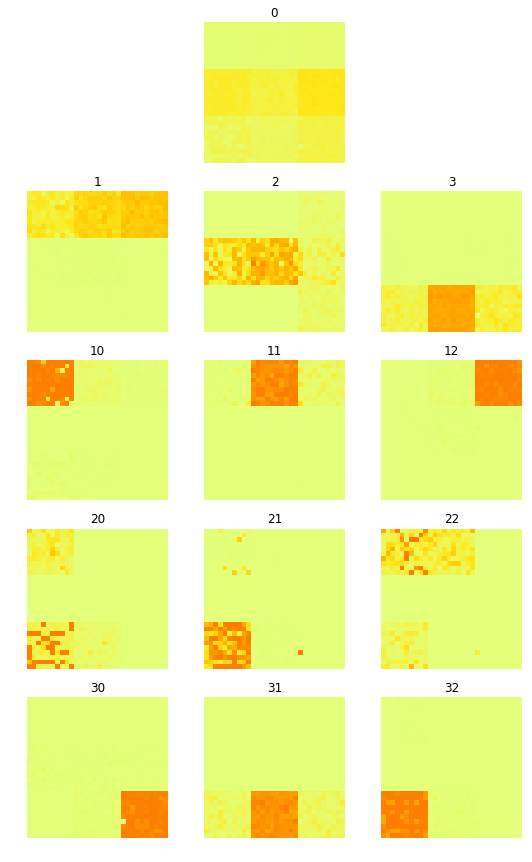

KeyboardInterrupt: 

In [23]:
if len(log_df) == 0:
    cmd_rm = 'rm -r %s' % config.modeldir
    res = subprocess.call(cmd_rm.split())

    cmd_mk = 'mkdir %s' % config.modeldir
    res = subprocess.call(cmd_mk.split())

time_start = time.time()
while epoch < config.epochs:
    for ct, batch in train_batches:
        feed_dict = get_feed_dict(batch)

        _, loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch, ppls_batch, global_step_log = \
        sess.run([opt, loss, topic_loss_recon, topic_loss_kl, topic_loss_reg, topic_ppls, tf.train.get_global_step()], feed_dict = feed_dict)

        losses_train += [[loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch]]
        ppls_train += list(ppls_batch)

        if global_step_log%config.log_period==0:
            loss_train, topic_loss_recon_train, topic_loss_kl_train, topic_loss_reg_train = np.mean(losses_train, 0)
            ppl_train = np.exp(np.mean(ppls_train))
            loss_dev, topic_loss_recon_dev, topic_loss_kl_dev, topic_loss_reg_dev, ppl_dev = get_loss(sess, dev_batches)
            
#             if loss_dev < loss_min:
#                 loss_min = loss_dev
#                 saver.save(sess, config.modelpath, global_step=global_step_log)

            clear_output()
    
            time_log = int(time.time() - time_start)
            log_series = pd.Series([time_log, epoch, ct, \
                    '%.2f'%loss_train, '%.0f'%ppl_train, '%.2f'%topic_loss_recon_train, '%.2f'%topic_loss_kl_train, '%.2f'%topic_loss_reg_train, \
                    '%.2f'%loss_dev, '%.0f'%ppl_dev, '%.2f'%topic_loss_recon_dev, '%.2f'%topic_loss_kl_dev, '%.2f'%topic_loss_reg_dev],
                    index=log_df.columns)
            log_df.loc[global_step_log] = log_series
            display(log_df)
            
            # visualize topic
            print_topic_sample()

            time_start = time.time()
            
    epoch += 1
    train_batches = get_batches(instances_train, config.batch_size, iterator=True)
    
display(log_df)
print_topic_sample()

# confirm variables

In [ ]:
states_topic_embeddings = tf.concat([tree_states_topic_embeddings[topic_idx] for topic_idx in topic_idxs], 0)

In [ ]:
debug_value([states_topic_embeddings[:, :6]])

In [ ]:
topic_embeddings = tf.concat([tree_topic_embeddings[topic_idx] for topic_idx in topic_idxs], 0)

In [ ]:
debug_value([topic_embeddings[:, :6]])

In [ ]:
_topics_bow, = debug_value([topic_bow], return_value=True)
np.max(_topics_bow)

In [ ]:
_topics_bow, = debug_value([topic_bow], return_value=True)

plt.figure(figsize=(12, 20))
    
_topic_bow = _topics_bow[0]
plt.subplot(5,3,2)
plt.ylim([0, np.max(_topics_bow)])
plt.bar(bow_idxs, _topic_bow)

for i in range(1, len(topic_idxs)):
    _topic_bow = _topics_bow[i]
    plt.subplot(5,3,i+3)
    plt.ylim([0, np.max(_topics_bow)])
#     plt.axis('off')
    plt.bar(bow_idxs, _topic_bow)

plt.show()

In [24]:
_prob_topics = []
for ct, batch in dev_batches:
    feed_dict = get_feed_dict(batch)
    _prob_topic, = sess.run([prob_topic], feed_dict = feed_dict)
    _prob_topics.append(_prob_topic)
    
_prob_topics = np.concatenate(_prob_topics, 0)
_prob_topic_mean = np.mean(_prob_topics, 0)

print(_prob_topic_mean)

[0.37399197 0.10826537 0.0361492  0.09407969 0.07117239 0.04244342
 0.05811434 0.02009552 0.01129199 0.01132447 0.09071141 0.0239397
 0.05842046]


In [ ]:
debug_value([topic_dots])

In [ ]:
debug_value([topic_losses_reg])

In [ ]:
tree_mask_reg

In [ ]:
_topic_bow, = debug_value([topic_bow], return_value=True)

In [ ]:
plt.bar(bow_idxs, _topic_bow[0])

In [ ]:
plt.bar(bow_idxs, _topic_bow[1])

In [ ]:
plt.bar(bow_idxs, _topic_bow[2])

In [ ]:
plt.bar(bow_idxs, _topic_bow[3])

In [ ]:
np.max(_topic_bow, 1)

In [ ]:
plt.bar(bow_idxs, _topic_bow[-5])

In [ ]:
plt.bar(bow_idxs, _topic_bow[-1])

In [ ]:
len(bow_idxs)

In [ ]:
debug_value([prob_topic[3]])

In [ ]:
debug_value([tf.exp(-tf.divide(topic_losses_recon, n_bow))])

### test

In [ ]:
debug_shape([bow, hidden_bow, latents_bow, prob_topic, bow_embeddings, topic_embeddings, topic_bow, prob_bow])

In [ ]:
debug_shape([topic_losses_recon, topic_loss_recon, n_bow, ppls, topic_embeddings_norm, tf.expand_dims(topic_angles_mean, -1), topic_angles_vars])

In [ ]:
debug_value([tf.reduce_sum(tf.square(topic_embeddings_norm), 1)], return_value=True)[0]

In [ ]:
debug_value([tf.reduce_sum(prob_topic, -1), tf.reduce_sum(topic_bow, -1), tf.reduce_sum(tf.exp(prob_bow), 1)])

In [ ]:
sigma_bow = tf.exp(0.5 * logvars_bow)
dist_bow = tfd.Normal(means_bow, sigma_bow)
dist_std = tfd.Normal(0., 1.)
topic_loss_kl_tmp = tf.reduce_mean(tf.reduce_sum(tfd.kl_divergence(dist_bow, dist_std), 1))

In [ ]:
debug_value([topic_loss_recon, topic_loss_kl, topic_loss_kl_tmp])

In [ ]:
_logvars, _means, _kl_losses, _latents, _output_logits = sess.run([logvars, means, kl_losses, latents, output_logits], feed_dict=feed_dict)


In [ ]:
_logvars.shape, _means.shape, _kl_losses.shape, _latents.shape

In [ ]:
_output_logits

In [ ]:
_output_logits, _dec_target_idxs_do, _dec_mask_tokens_do, _recon_loss, _kl_losses, _ = sess.run([output_logits, dec_target_idxs_do, dec_mask_tokens_do, recon_loss, kl_losses, opt], feed_dict=feed_dict)


In [ ]:
tf.reduce_max(output_logits, 2).eval(session=sess, feed_dict=feed_dict).shape

In [ ]:
_output_logits.shape, _dec_target_idxs_do.shape, _dec_mask_tokens_do.shape

In [ ]:
_logits = np.exp(_output_logits) / np.sum(np.exp(_output_logits), 2)[:, :, None]

In [ ]:
_idxs = _dec_target_idxs_do

In [ ]:
_losses = np.array([[-np.log(_logits[i, j, _idxs[i, j]]) for j in range(_idxs.shape[1])] for i in range(_idxs.shape[0])]) * _dec_mask_tokens_do

In [ ]:
np.sum(_losses)/np.sum(_dec_mask_tokens_do)

In [ ]:
_recon_loss

In [ ]:
_kl_losses.shape